In [1]:
%cd ../../

/home/dmoreno/ATAT_ZTF/elasticc_one


In [33]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import os

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from itertools import groupby

#from utils import get_metrics, plot_values_times, plot_result_ablation, f1_values

In [34]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [48]:
ROOT = './data/datasets/ZTF_ff'

path_data = '{}/final/LC_MD_FEAT_v3_fixed_linspace_logspace_times_200'.format(ROOT)
path_results = './results/ZTF_ff/LC_MD_FEAT/lc_md_feat_mta_v3_fixed_linspace_logspace_times/MTA'
time_to_eval = 2048

order_classes = ['SNIa',
                 'SNIbc',
                 'SNIIb',
                 'SNII',
                 'SNIIn',
                 'SLSN',
                 'TDE',
                 'Microlensing',
                 'QSO', 
                 'AGN',
                 'Blazar', 
                 'YSO', 
                 'CV/Nova', 
                 'LPV', 
                 'EA', 
                 'EB/EW',
                 'Periodic-Other', 
                 'RSCVn', 
                 'CEP', 
                 'RRLab', 
                 'RRLc', 
                 'DSCT']

In [49]:
objects_partitions = pd.read_parquet('{}/partitions/v3/partitions.parquet'.format(ROOT))
obj_label = objects_partitions[objects_partitions['partition'] == 'test']
y_real_test = obj_label['alerceclass'].values
obj_label = ['aid_{}'.format(x) for x in obj_label['oid'].values]

In [50]:
import yaml

def load_yaml(path):
    with open(path, 'r') as file:
        args = yaml.load(file, Loader=yaml.FullLoader)
    return args

dict_info = load_yaml('{}/dict_info.yaml'.format(path_data))

mapping_classes = dict_info['mapping_classes']
mapping_classes_inverted = {v: k for k, v in mapping_classes.items()}
print(mapping_classes_inverted)

{0: 'AGN', 8: 'Blazar', 12: 'CEP', 5: 'CV/Nova', 15: 'DSCT', 2: 'EA', 10: 'EB/EW', 11: 'LPV', 21: 'Microlensing', 14: 'Periodic-Other', 1: 'QSO', 13: 'RRLab', 6: 'RRLc', 7: 'RSCVn', 17: 'SLSN', 9: 'SNII', 19: 'SNIIb', 20: 'SNIIn', 4: 'SNIa', 16: 'SNIbc', 18: 'TDE', 3: 'YSO'}


In [51]:
def sort_dict_by_value(d, reverse=False):
    return dict(sorted(d.items(), key=lambda x: x[1], reverse=reverse))

sort_classes = list(sort_dict_by_value(mapping_classes).keys())
print(sort_classes)

['AGN', 'QSO', 'EA', 'YSO', 'SNIa', 'CV/Nova', 'RRLc', 'RSCVn', 'Blazar', 'SNII', 'EB/EW', 'LPV', 'CEP', 'RRLab', 'Periodic-Other', 'DSCT', 'SNIbc', 'SLSN', 'TDE', 'SNIIb', 'SNIIn', 'Microlensing']


In [55]:
predictions = torch.load('{}/all_predictions_times.pt'.format(path_results))

if dict_info['type_windows'] == 'windows':
    snids_str = [snid.decode("utf-8") for snid in predictions['SNID']]

    # Función para extraer el identificador base de cada SNID
    def base_id(snid):
        return "_".join(snid.split("_")[:-1])

    # Agrupar por el identificador base
    grouped = groupby(range(len(snids_str)), key=lambda x: base_id(snids_str[x]))
    idx_windows_objects = [list(group) for _, group in grouped]

    idx_unique_y_test = []
    ids_unique_real = []

    for i, snid in enumerate(snids_str):
        if snid.endswith("_0"):
            idx_unique_y_test.append(i)
            ids_unique_real.append('aid_{}'.format(snid.split('_')[0]))

    # Calcular el promedio de las probabilidades para cada conjunto de ventanas
    predictions.update({
        'list_y_pred_prob_avg': dict(),
        })

    for eval_time, predicciones in predictions['list_y_pred_prob'].items():
        predictions['list_y_pred_prob_avg'][eval_time] = [] 
        for idx_windows in idx_windows_objects:
            window_probs = predicciones[idx_windows]
            avg_probs = np.mean(window_probs, axis=0)
            predictions['list_y_pred_prob_avg'][eval_time].append(avg_probs)

        predictions['list_y_pred_prob_avg'][eval_time] = np.array(predictions['list_y_pred_prob_avg'][eval_time])

    predictions['list_y_pred_prob'] = predictions.pop('list_y_pred_prob_avg')
    #predictions['list_y_pred'] = predictions.pop('list_y_pred_avg')
    predictions['SNID'] = ids_unique_real
    predictions['y_test'] = predictions['y_test'][idx_unique_y_test]

else:
    predictions['SNID'] = ['aid_{}'.format(snid.decode("utf-8")) for snid in predictions['SNID']]

df_atat_pred = []
for eval_time, prob_classes in predictions['list_y_pred_prob'].items():
    df = pd.DataFrame(prob_classes, columns=sort_classes)
    df['shorten'] = str(eval_time.split('_')[-1])
    df.index = predictions['SNID']
    df_atat_pred.append(df)
df_atat_pred = pd.concat(df_atat_pred)
df_atat_pred

,AGN,QSO,EA,YSO,SNIa,CV/Nova,RRLc,RSCVn,Blazar,SNII,...,RRLab,Periodic-Other,DSCT,SNIbc,SLSN,TDE,SNIIb,SNIIn,Microlensing,shorten
aid_ZTF17aaaecgi,6.332512e-06,9.072622e-07,5.763298e-01,3.961901e-02,1.726821e-05,0.000650,5.511053e-03,1.577260e-03,3.437789e-06,6.680474e-07,...,1.777109e-03,2.668324e-04,1.270036e-02,1.585977e-06,1.163423e-08,8.606948e-09,1.445382e-08,1.656143e-06,3.314270e-09,16
aid_ZTF17aaaedvi,3.119321e-06,1.775580e-07,2.121783e-04,2.911787e-03,1.476184e-05,0.000248,6.323139e-06,4.255838e-04,8.367476e-07,4.539132e-06,...,1.704973e-05,2.332234e-03,3.014523e-04,3.695634e-06,1.226136e-08,1.234036e-08,7.806331e-11,4.281141e-07,3.423215e-09,16
aid_ZTF17aaafglk,1.497392e-05,3.674604e-04,4.234710e-02,1.951494e-03,6.229345e-05,0.598996,5.101500e-02,9.670805e-03,8.950667e-04,1.489515e-05,...,4.069524e-02,1.925933e-01,2.871449e-02,1.411509e-05,7.045950e-06,1.647407e-07,2.350309e-06,4.070223e-05,2.001440e-08,16
aid_ZTF17aaafiut,1.229505e-05,3.123213e-06,5.678856e-01,2.866346e-02,3.587701e-05,0.003439,3.510207e-02,4.226610e-03,5.001128e-06,3.480327e-06,...,5.405571e-03,1.152561e-03,1.939748e-01,5.214007e-06,1.119401e-07,2.330714e-08,3.027856e-07,2.404524e-05,5.869345e-09,16
aid_ZTF17aaafiww,1.084369e-05,6.605939e-06,2.070988e-01,6.294919e-02,2.397431e-05,0.013166,1.000300e-01,1.214969e-02,2.356576e-05,1.115787e-06,...,8.070845e-02,3.256116e-03,1.778096e-01,3.267138e-06,3.363019e-08,5.426908e-09,4.815986e-09,5.333229e-06,3.774081e-09,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
aid_ZTF23aamapva,4.018699e-06,1.017995e-06,2.045664e-04,1.708836e-05,7.292343e-07,0.000251,1.895362e-03,7.510551e-04,1.039156e-06,1.640079e-07,...,7.006554e-05,9.870843e-01,5.176454e-03,2.157898e-07,4.195762e-08,4.439217e-10,3.896924e-09,8.548475e-07,1.504992e-11,2048
aid_ZTF23aamsarj,1.539310e-08,1.637243e-08,1.025977e-08,7.206239e-09,1.046564e-01,0.000024,4.211853e-09,3.532748e-08,9.936560e-09,8.017856e-01,...,1.842608e-08,1.048651e-08,1.946865e-08,6.573739e-02,6.540395e-07,4.651113e-11,1.103199e-05,2.778468e-02,1.782764e-09,2048
aid_ZTF23aamxeoe,7.587817e-06,5.048245e-06,2.916056e-07,9.487825e-07,3.323230e-02,0.002056,3.150323e-06,8.875516e-06,4.774239e-06,5.953546e-02,...,1.764120e-06,9.380245e-06,2.128700e-06,4.638289e-02,8.979972e-02,1.114656e-05,4.120739e-07,7.689274e-01,5.995637e-08,2048
aid_ZTF23aavxvsz,9.697168e-05,2.638418e-06,2.457377e-06,1.669087e-05,9.680361e-01,0.000016,2.610041e-07,1.840442e-05,5.477416e-05,5.546847e-03,...,1.173115e-07,2.139099e-06,1.899842e-07,2.503167e-02,6.210061e-06,9.438123e-07,1.115780e-03,4.386381e-05,4.014570e-07,2048


In [ ]:
atat_pred_2048_time_test = df_atat_pred[df_atat_pred['shorten'] == '2048']
atat_pred_2048_time_test = atat_pred_2048_time_test.reindex(obj_label)[sort_classes]
atat_pred_2048_time_test

In [20]:
y_pred_test = atat_pred_2048_time_test.idxmax(axis=1).values
y_pred_test

array(['AGN', 'QSO', 'LPV', ..., 'YSO', 'RRLab', 'YSO'], dtype=object)

In [21]:
y_real_test

array(['AGN', 'QSO', 'EA', ..., 'YSO', 'RRLab', 'YSO'], dtype=object)

# Evaluating performance over time

In [45]:
import torch 

def get_metrics(exp_name, clf_type='mix'):
    dict_clf = {
        'lc': 'list_y_pred_lc_times',
        'tab': 'list_y_pred_tab_times',
        'mix': 'list_y_pred_mix_times'
    }

    predictions = torch.load('src/results/ZTF/BALTO/{}/predictions_times.pt'.format(exp_name))
    
    f1_results_time = dict()
    bacc_results_time = dict()
    acc_results_time = dict()
    precision_results_time = dict()
    recall_results_time = dict()
    for set_type, y_pred in predictions[dict_clf[clf_type]].items():
        f1_results_time[set_type] = f1_score(predictions['y_test'], y_pred, average='macro')
        bacc_results_time[set_type] = balanced_accuracy_score(predictions['y_test'], y_pred)
        acc_results_time[set_type] = accuracy_score(predictions['y_test'], y_pred)
        precision_results_time[set_type] = precision_score(predictions['y_test'], y_pred, average='macro')
        recall_results_time[set_type] = recall_score(predictions['y_test'], y_pred, average='macro')

    return f1_results_time #, bacc_results_time, acc_results_time, precision_results_time, recall_results_time

In [67]:
def plot_values_times(list_eval_time, models_f1_results_time, title=None, 
                      ylim_min=0, ylim_max=90, colors=None, f1_added=None):
    fs = 17

    plt.figure(figsize=(8, 7))

    for name_model, f1_results_time in models_f1_results_time.items():

        list_f1_mean_fold = []
        for eval_time in list_eval_time:
            list_f1_mean_fold.append(f1_results_time['test_{}'.format(eval_time)]*100)

        print(list_f1_mean_fold)

        if name_model.find('MTA') != -1: 
            plt.plot(np.log(list_eval_time)/np.log(2), list_f1_mean_fold, label=name_model, linestyle='dashed')#, color=colors[name_model])
            #plt.fill_between(np.log(list_eval_time)/np.log(2), 
            #                list_f1_mean_fold + list_f1_std_fold, 
            #                list_f1_mean_fold - list_f1_std_fold, 
            #                alpha=0.4, color=colors[name_model])

        else:
            plt.plot(np.log(list_eval_time)/np.log(2), list_f1_mean_fold, label=name_model)#, color=colors[name_model])
            #plt.fill_between(np.log(list_eval_time)/np.log(2), 
            #                 list_f1_mean_fold + list_f1_std_fold, 
            #                 list_f1_mean_fold - list_f1_std_fold, 
            #                 alpha=0.5, color=colors[name_model])

            #plt.show()


    if f1_added is not None:
        plt.plot(np.log(list_eval_time)/np.log(2), f1_added['mean']*100, label='RF (Features + MD)', linestyle='-', color='#e41a1c')
    
        plt.fill_between(np.log(list_eval_time)/np.log(2), 
                        f1_added['mean']*100 + f1_added['std']*100, 
                        f1_added['mean']*100 - f1_added['std']*100, 
                        alpha=0.4, color='#e41a1c')
            
    plt.yticks(fontsize=fs)
    plt.xticks(np.log(list_eval_time)/np.log(2), list_eval_time, fontsize=fs)

    plt.ylabel("F1-Score", fontsize=fs, labelpad=13)
    plt.xlabel("Evaluated time (days after first alert)", fontsize=fs, labelpad=13)

    plt.ylim((ylim_min, ylim_max))
    plt.legend(fontsize=fs) #, loc='lower right')

    #plt.savefig("all_curves_teval_a_last.pdf", format="pdf", bbox_inches="tight")
    plt.show()

In [68]:
f1_lc = get_metrics(exp_name='epoch1000_patience30_lr1e-4_MAX200', clf_type='lc')
f1_lc_over = get_metrics(exp_name='epoch1000_patience30_lr1e-4_MAX200_oversampling', clf_type='lc')
f1_lc_window = get_metrics(exp_name='epoch1000_patience30_lr1e-4_MAX200_window', clf_type='lc')
f1_lc_g = get_metrics(exp_name='epoch1000_patience30_lr1e-4_MAX200_band_g', clf_type='lc')
f1_lc_r = get_metrics(exp_name='epoch1000_patience30_lr1e-4_MAX200_band_r', clf_type='lc')
f1_lc_md = get_metrics(exp_name='epoch1000_patience30_lr1e-4_MAX200_lc_md1', clf_type='mix')

[3.6096576701300584, 4.446612065450422, 5.59620910816614, 9.619080935457847, 16.789848613750898, 23.47858221980553, 30.2437932377458, 42.88506578989324, 54.50033181872307]
[25.734524495531158, 27.649349568692017, 30.92672363075294, 35.328808061219846, 43.244009812326674, 47.372187088878825, 52.026043268435586, 58.51526229362537, 67.07505335170492]


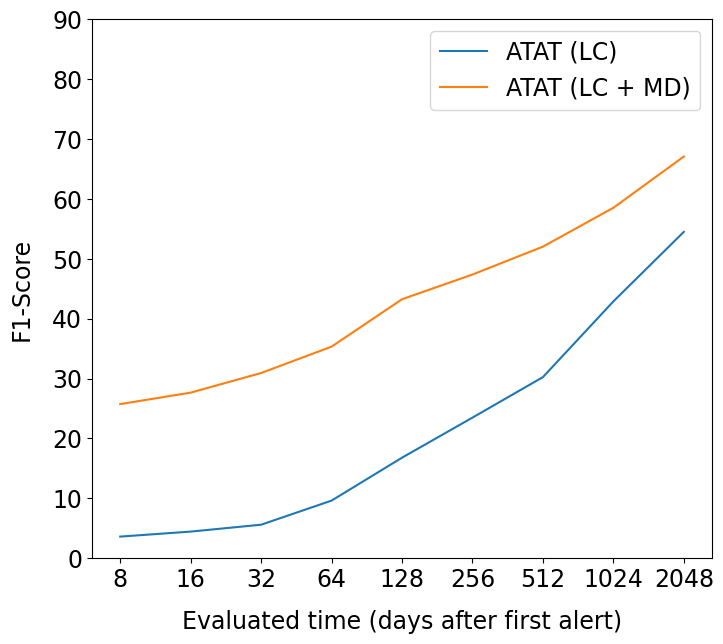

In [69]:
list_eval_time = [8, 16, 32, 64, 128, 256, 512, 1024, 2048]
models_f1_results_time = {
    'ATAT (LC)': f1_lc,
    'ATAT (LC + MD)': f1_lc_md,
}

plot_values_times(list_eval_time, models_f1_results_time)

[3.6096576701300584, 4.446612065450422, 5.59620910816614, 9.619080935457847, 16.789848613750898, 23.47858221980553, 30.2437932377458, 42.88506578989324, 54.50033181872307]
[3.4511918482397, 4.860536846671353, 7.881198716577805, 12.417720106392517, 18.3328867830215, 22.537778363394565, 29.243693445343965, 41.2204248419813, 53.50175102785734]
[18.311734588613895, 22.52874969824704, 28.164580887117307, 34.819763322635126, 40.510609323124136, 45.78364248827594, 50.544834347933055, 51.40599496164916, 51.70746151165714]
[4.5513253867459, 4.8438458240259585, 5.95575759061399, 9.566691165762796, 12.43009848425896, 15.587110203415985, 23.3325851111872, 38.65062300068646, 50.402740031555695]
[2.7038300894311087, 3.2394370271609914, 5.656535932284865, 9.125071740129574, 12.147588848888823, 17.940365326511753, 22.93971651094173, 34.67239106058197, 49.050166496192595]
[25.734524495531158, 27.649349568692017, 30.92672363075294, 35.328808061219846, 43.244009812326674, 47.372187088878825, 52.026043268

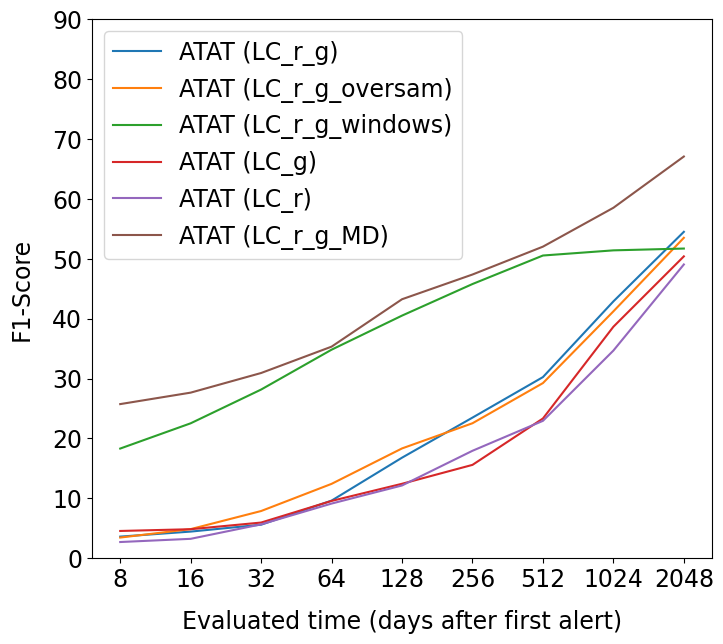

In [72]:
list_eval_time = [8, 16, 32, 64, 128, 256, 512, 1024, 2048]
models_f1_results_time = {
    'ATAT (LC_r_g)': f1_lc,
    'ATAT (LC_r_g_oversam)': f1_lc_over,
    'ATAT (LC_r_g_windows)': f1_lc_window,
    'ATAT (LC_g)': f1_lc_g,
    'ATAT (LC_r)': f1_lc_r,

    'ATAT (LC_r_g_MD)': f1_lc_md,
}

plot_values_times(list_eval_time, models_f1_results_time)

In [ ]:
f1_lc = get_metrics(exp_name='epoch1000_patience30_lr1e-4_MAX200', clf_type='lc')
f1_lc_over = get_metrics(exp_name='epoch1000_patience30_lr1e-4_MAX200_oversampling', clf_type='lc')
f1_lc_window = get_metrics(exp_name='epoch1000_patience30_lr1e-4_MAX200_window', clf_type='lc')
f1_lc_g = get_metrics(exp_name='epoch1000_patience30_lr1e-4_MAX200_band_g', clf_type='lc')
f1_lc_r = get_metrics(exp_name='epoch1000_patience30_lr1e-4_MAX200_band_r', clf_type='lc')
f1_lc_md = get_metrics(exp_name='epoch1000_patience30_lr1e-4_MAX200_lc_md1', clf_type='mix')

In [ ]:
list_eval_time = [8, 16, 32, 64, 128, 256, 512, 1024, 2048]
models_f1_results_time = {
    'ATAT (LC)': f1_lc,
    'ATAT (LC + MTA)': f1_lc_mtime,
}

plot_values_times(list_eval_time, models_f1_results_time, colors=colors)

In [ ]:
for set_type, batches_pred in dict_pred_times.items():
    f1_results_time['fold_{}'.format(i)][set_type] = f1_score(target, 
                                                                np.argmax(batches_pred, axis = 1), 
                                                                average='macro')

In [6]:
f1_lc_header_mtime, _, _, _ = get_metrics(list_path_predictions='{}/lc_tab/Exp_cfg_-arch=lc_header_mtime-seed=*'.format(name_file_results))
f1_lc_header_feat_mtime, _, _, _ = get_metrics(list_path_predictions='{}/lc_tab/Exp_cfg_-arch=lc_header_feat_mtime-seed=*'.format(name_file_results))

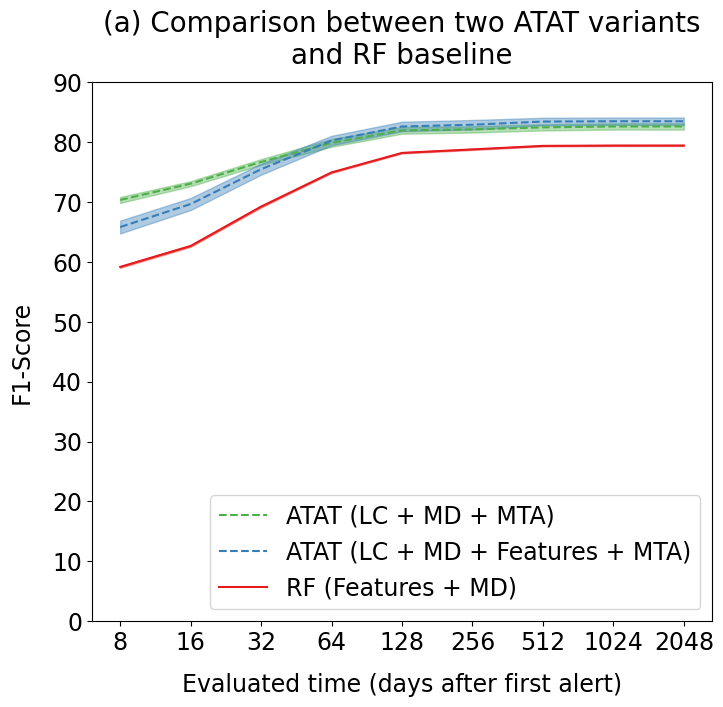

In [7]:
list_eval_time = [8, 16, 32, 64, 128, 256, 512, 1024, 2048]
models_f1_results_time = {
    'ATAT (LC + MD + MTA)': f1_lc_header_mtime,
    'ATAT (LC + MD + Features + MTA)': f1_lc_header_feat_mtime,
}

title = '(a) Comparison between two ATAT variants\nand RF baseline'
plot_values_times(list_eval_time, models_f1_results_time, title, colors=colors, f1_added=f1_added)

## Plot 1

In [8]:
f1_lc, _, _, _ = get_metrics(list_path_predictions='{}/lc/Exp_cfg_-arch=lc-seed=*'.format(name_file_results))
f1_lc_mtime, _, _, _ = get_metrics(list_path_predictions='{}/lc/Exp_cfg_-arch=lc_mtime-seed=*'.format(name_file_results))

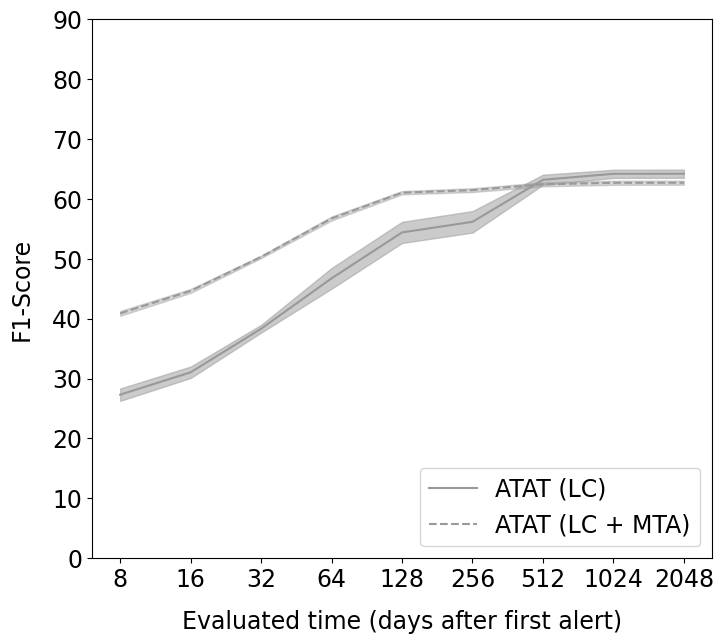

In [9]:
list_eval_time = [8, 16, 32, 64, 128, 256, 512, 1024, 2048]
models_f1_results_time = {
    'ATAT (LC)': f1_lc,
    'ATAT (LC + MTA)': f1_lc_mtime,
}

plot_values_times(list_eval_time, models_f1_results_time, colors=colors)

## Plot 2

In [10]:
f1_features, _, _, _ = get_metrics(list_path_predictions='{}/tab/Exp_cfg_-arch=features-seed=*'.format(name_file_results))
f1_features_mtime, _, _, _ = get_metrics(list_path_predictions='{}/tab/Exp_cfg_-arch=features_mtime-seed=*'.format(name_file_results))
f1_header_feat, _, _, _ = get_metrics(list_path_predictions='{}/tab/Exp_cfg_-arch=header_feat-seed=*'.format(name_file_results))
f1_header_feat_mtime, _, _, _ = get_metrics(list_path_predictions='{}/tab/Exp_cfg_-arch=header_feat_mtime-seed=*'.format(name_file_results))
f1_header, _, _, _ = get_metrics(list_path_predictions='{}/tab/Exp_cfg_-arch=header-seed=*'.format(name_file_results))

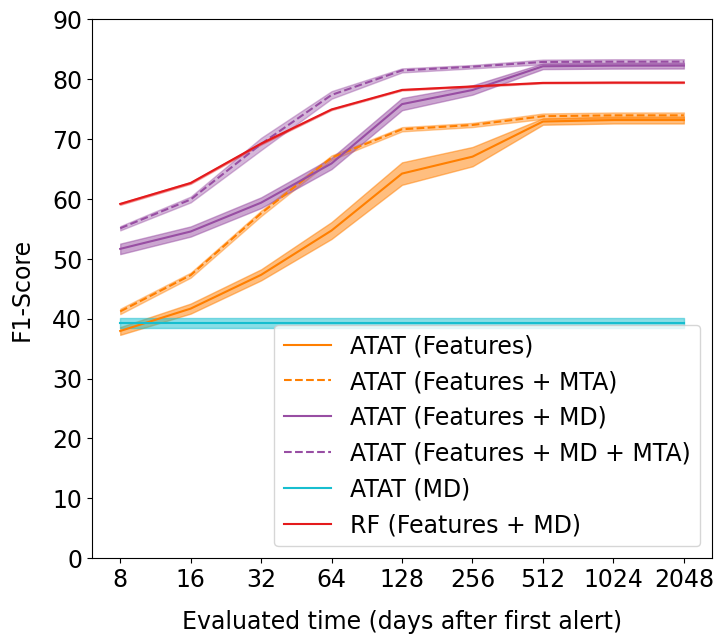

In [11]:
list_eval_time = [8, 16, 32, 64, 128, 256, 512, 1024, 2048]
models_f1_results_time = {
    'ATAT (Features)': f1_features,
    'ATAT (Features + MTA)': f1_features_mtime,
    'ATAT (Features + MD)': f1_header_feat,
    'ATAT (Features + MD + MTA)': f1_header_feat_mtime,
    'ATAT (MD)': f1_header,
}

plot_values_times(list_eval_time, models_f1_results_time, colors=colors, f1_added=f1_added)

## Plot 3

In [12]:
f1_lc_header, _, _, _ = get_metrics(list_path_predictions='{}/lc_tab/Exp_cfg_-arch=lc_header-seed=*'.format(name_file_results))
f1_lc_header_mtime, _, _, _ = get_metrics(list_path_predictions='{}/lc_tab/Exp_cfg_-arch=lc_header_mtime-seed=*'.format(name_file_results))
f1_lc_header_feat, _, _, _ = get_metrics(list_path_predictions='{}/lc_tab/Exp_cfg_-arch=lc_header_feat-seed=*'.format(name_file_results))
f1_lc_header_feat_mtime, _, _, _ = get_metrics(list_path_predictions='{}/lc_tab/Exp_cfg_-arch=lc_header_feat_mtime-seed=*'.format(name_file_results))

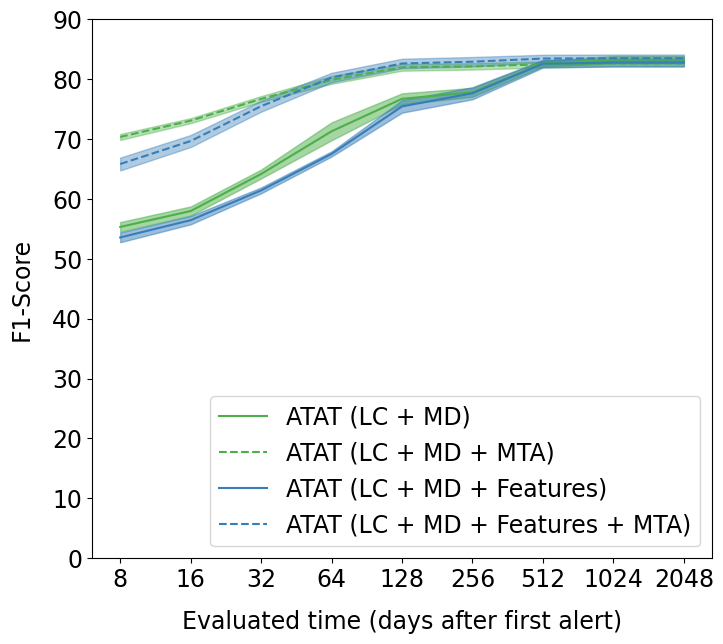

In [13]:
list_eval_time = [8, 16, 32, 64, 128, 256, 512, 1024, 2048]
models_f1_results_time = {
    'ATAT (LC + MD)': f1_lc_header,
    'ATAT (LC + MD + MTA)': f1_lc_header_mtime,
    'ATAT (LC + MD + Features)': f1_lc_header_feat,
    'ATAT (LC + MD + Features + MTA)': f1_lc_header_feat_mtime,
}

plot_values_times(list_eval_time, models_f1_results_time, colors=colors)

## Joint plot

In [14]:
list_eval_time = [8, 16, 32, 64, 128, 256, 512, 1024, 2048]

models_f1_results_time = {
    'ATAT (LC)': f1_lc,
    'ATAT (LC + MTA)': f1_lc_mtime,
    'ATAT (Features)': f1_features,
    'ATAT (Features + MTA)': f1_features_mtime,
    'ATAT (Features + MD)': f1_header_feat,
    'ATAT (Features + MD + MTA)': f1_header_feat_mtime,
    'ATAT (MD)': f1_header,
    'ATAT (LC + MD)': f1_lc_header,
    'ATAT (LC + MD + MTA)': f1_lc_header_mtime,
    'ATAT (LC + MD + Features)': f1_lc_header_feat,
    'ATAT (LC + MD + Features + MTA)': f1_lc_header_feat_mtime,
}

In [15]:
dict_mean, dict_std = f1_values(list_eval_time, models_f1_results_time)

In [16]:
order_models = [['ATAT (LC)', 'ATAT (LC + MTA)'], 
                ['ATAT (Features)', 'ATAT (Features + MTA)', 'ATAT (Features + MD)', 'ATAT (Features + MD + MTA)', 'ATAT (MD)'],
                ['ATAT (LC + MD)', 'ATAT (LC + MD + MTA)', 'ATAT (LC + MD + Features)', 'ATAT (LC + MD + Features + MTA)']]

In [17]:
titles = ['(b) Light-curve only ATAT variants\n',
          '(c) Tabular data only ATAT variants\nplus RF baseline',
          '(d) Combined Light-curve and tabular\ndata ATAT variants']

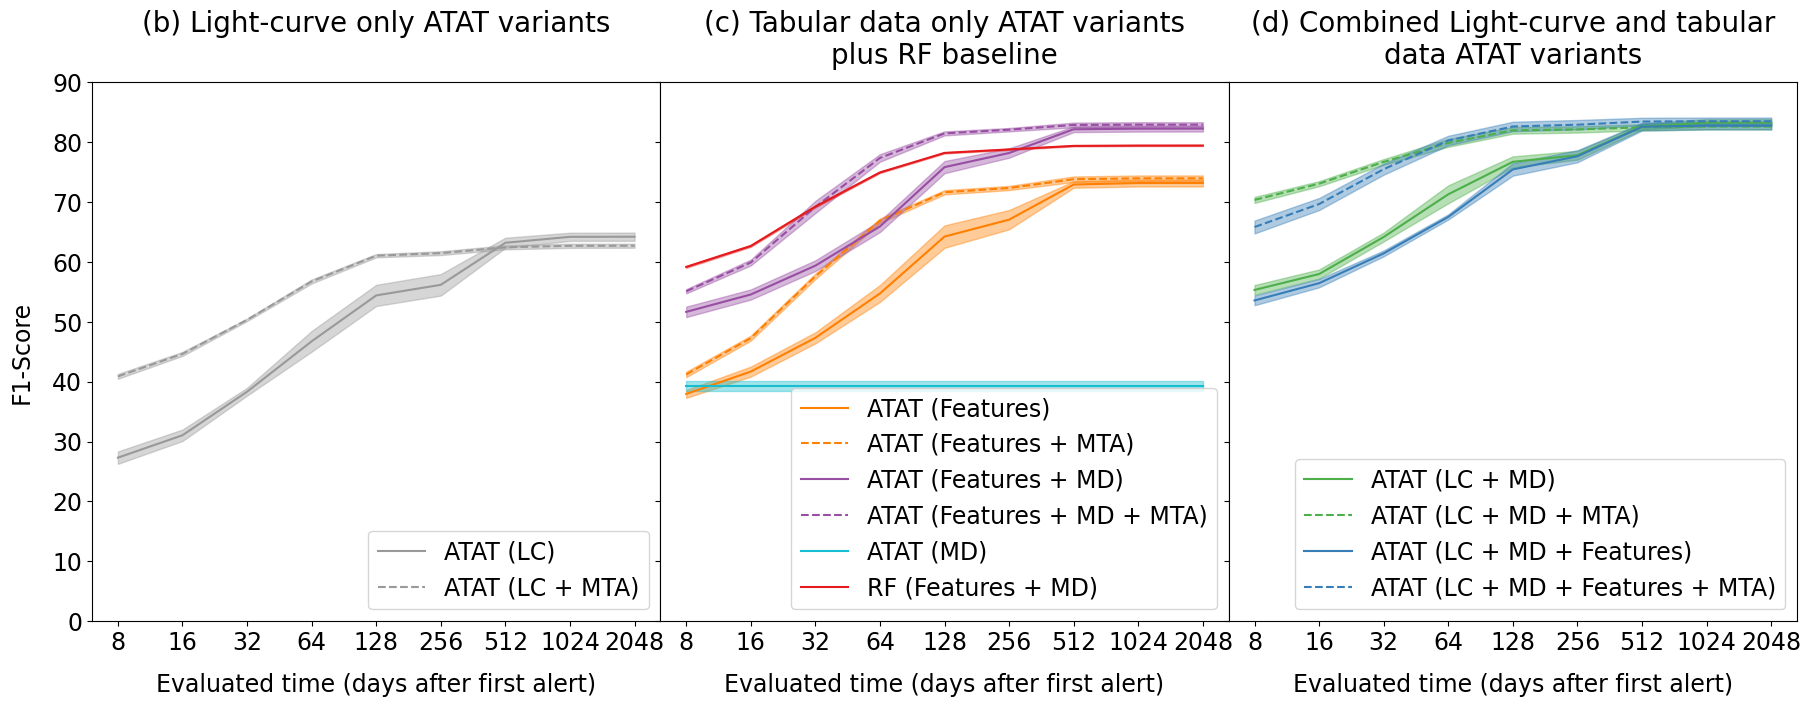

In [18]:
fs = 17
ylim_min = 0
ylim_max = 90


fig, axes = plt.subplots(1, 3, figsize=(22, 7), sharey=True, gridspec_kw=dict(wspace=0))

for i, models_in_plot in enumerate(order_models):
    axes[i].set_title(titles[i], size=20, pad=13)

    for name_model in models_in_plot:
        list_f1_mean_fold = dict_mean[name_model]
        list_f1_std_fold = dict_std[name_model]

        if name_model.find('MTA') != -1:
            linestyle='dashed'
        else:
            linestyle='-'

        axes[i].plot(np.log(list_eval_time)/np.log(2), list_f1_mean_fold, label=name_model, linestyle=linestyle, color=colors[name_model])
    
        axes[i].fill_between(np.log(list_eval_time)/np.log(2), 
                             list_f1_mean_fold + list_f1_std_fold, 
                             list_f1_mean_fold - list_f1_std_fold, 
                             alpha=0.4, color=colors[name_model])

        axes[i].tick_params(axis="y", labelsize=fs) 
        axes[i].set_xticks(np.log(list_eval_time)/np.log(2)) 
        axes[i].set_xticklabels(list_eval_time, fontsize=fs)

        if i == 0: axes[i].set_ylabel("F1-Score", fontsize=fs, labelpad=13)
        axes[i].set_xlabel("Evaluated time (days after first alert)", fontsize=fs, labelpad=13)

        axes[i].set_ylim((ylim_min, ylim_max))
        axes[i].legend(fontsize=fs, loc='lower right')

axes[1].plot(np.log(list_eval_time)/np.log(2), f1_added['mean']*100, label='RF (Features + MD)', linestyle='-', color='#e41a1c')

axes[1].fill_between(np.log(list_eval_time)/np.log(2), 
                f1_added['mean']*100 + f1_added['std']*100, 
                f1_added['mean']*100 - f1_added['std']*100, 
                alpha=0.4, color='#e41a1c')

axes[1].legend(fontsize=fs, loc='lower right')

#plt.savefig("all_curves_teval_b_c_d_last.pdf", format="pdf", bbox_inches="tight")
plt.show()


## Ablation study

In [19]:
f1_tm_lc, _, _, _ = get_metrics(list_path_predictions='{}/lc/Exp_cfg_-arch=lc_mtime-seed=*'.format(name_file_results))
f1_pe_lc, _, _, _ = get_metrics(list_path_predictions='{}/ablation/Exp_cfg_-arch=lc_pos_enc_mtime-seed=*'.format(name_file_results))

f1_tm_lc_md, _, _, _ = get_metrics(list_path_predictions='{}/ablation/Exp_cfg_-arch=lc_header_mtime_no_qt-seed=*'.format(name_file_results))
f1_pe_lc_md, _, _, _ = get_metrics(list_path_predictions='{}/ablation/Exp_cfg_-arch=lc_header_pos_enc_mtime_no_qt-seed=*'.format(name_file_results))

f1_tm_lc_md_qt, _, _, _ = get_metrics(list_path_predictions='{}/lc_tab/Exp_cfg_-arch=lc_header_mtime-seed=*'.format(name_file_results))
f1_pe_lc_md_qt, _, _, _ = get_metrics(list_path_predictions='{}/ablation/Exp_cfg_-arch=lc_header_pos_enc_mtime-seed=*'.format(name_file_results))

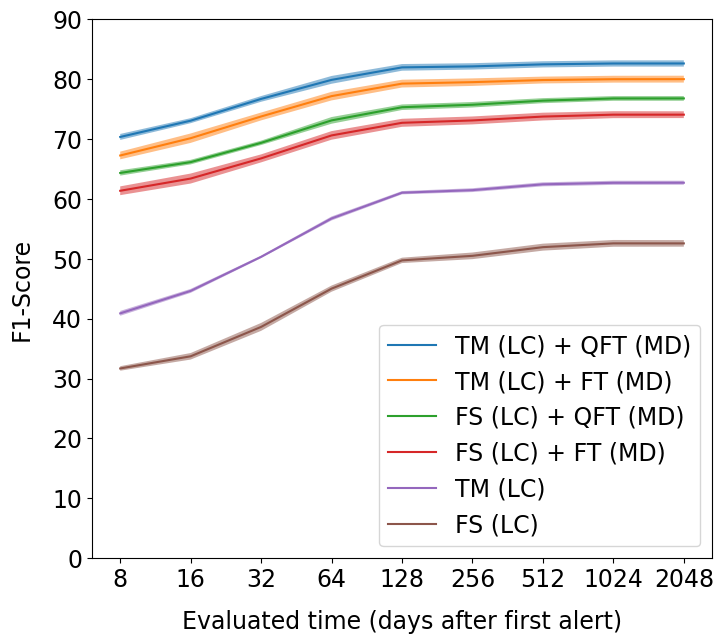

In [20]:
list_eval_time = [8, 16, 32, 64, 128, 256, 512, 1024, 2048]

models_f1_results_time = {
    'TM (LC) + QFT (MD)': f1_tm_lc_md_qt,
    'TM (LC) + FT (MD)': f1_tm_lc_md,
    'FS (LC) + QFT (MD)': f1_pe_lc_md_qt,
    'FS (LC) + FT (MD)': f1_pe_lc_md,
    'TM (LC)': f1_tm_lc,
    'FS (LC)': f1_pe_lc,
}

plot_result_ablation(list_eval_time, models_f1_results_time)